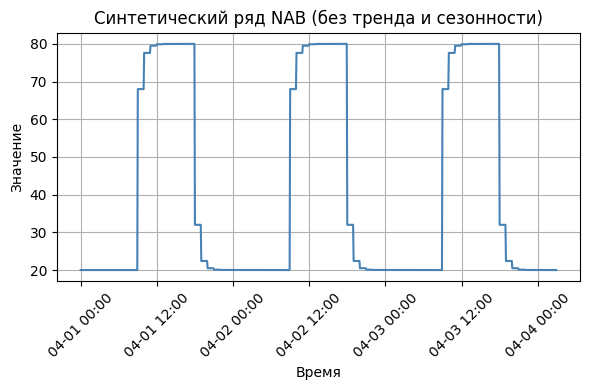

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def plot_series(file_path, title, time_col='timestamp', value_col='value'):
    df = pd.read_csv(file_path)
    df.columns = [col.lower() for col in df.columns]
    
    # Ограничим число точек для наглядности
    df = df.head(900)
    df[time_col] = pd.to_datetime(df[time_col])
    
    plt.figure(figsize=(6, 4))
    plt.plot(df[time_col], df[value_col], color='steelblue')
    plt.title(title)
    plt.xlabel('Время')
    plt.ylabel('Значение')
    plt.grid(True)
    
    # Форматируем дату как "месяц-день часы:минуты"
    date_format = mdates.DateFormatter('%m-%d %H:%M')
    plt.gca().xaxis.set_major_formatter(date_format)
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.savefig('graf_ART.png')
    plt.show()

plot_series('TIMES/art_daily_no_noise.csv', 'Синтетический ряд NAB (без тренда и сезонности)')


             timestamp  value
0  2014-04-01 00:00:00   20.0
1  2014-04-01 00:05:00   20.0
2  2014-04-01 00:10:00   20.0
3  2014-04-01 00:15:00   20.0
4  2014-04-01 00:20:00   20.0
Epoch 1/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.1077 - val_loss: 0.0154
Epoch 2/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0109 - val_loss: 0.0135
Epoch 3/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0117 - val_loss: 0.0102
Epoch 4/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0076 - val_loss: 0.0123
Epoch 5/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0111 - val_loss: 0.0094
Epoch 6/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0074 - val_loss: 0.0081
Epoch 7/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0079 - val_loss: 0.0079
Epoch 8/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0057 - val_loss: 0.0064
Epoch 9/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0056 - val_loss: 0.0081
Epoch 10/50
101/101 ━━━━━━━━━━━━━━━━━━━━

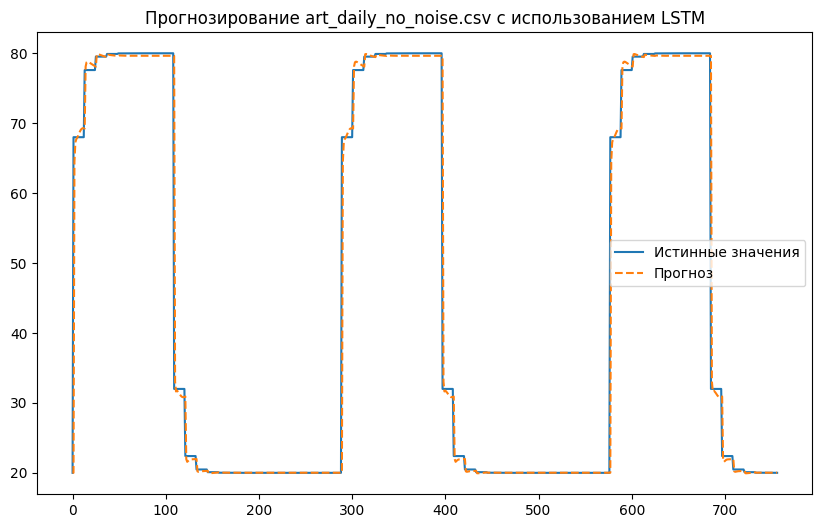

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import Input

# 1. Загрузка данных из файла
file_path = "TIMES/art_daily_no_noise.csv"
df = pd.read_csv(file_path)

# Проверяем содержимое файла
print(df.head())

# Преобразование timestamp в формат datetime и установка индекса
df["timestamp"] = pd.to_datetime(df["timestamp"])
df.set_index("timestamp", inplace=True)

# 2. Подготовка данных
# Ресемплинг данных, если необходимо (например, для равномерного временного ряда)
df = df.resample("5min").mean()

# Масштабирование значений в диапазон [0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))
df["value"] = scaler.fit_transform(df[["value"]])

# Создание входных (X) и выходных (y) последовательностей
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i : i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

sequence_length = 50  # Длина входной последовательности
data_values = df["value"].values
X, y = create_sequences(data_values, sequence_length)


test_size = 0.2  # 20% для тестового набора
test_split_idx = int(len(data_values) * (1 - test_size))

X_train, X_test = X[:test_split_idx], X[test_split_idx:]
y_train, y_test = y[:test_split_idx], y[test_split_idx:]


# Преобразование данных в 3D-формат для LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# 3. Построение модели LSTM
model = Sequential()
model.add(Input(shape=(sequence_length, 1)))  # Явно задаем вход
model.add(LSTM(50, activation="relu"))
model.add(Dense(1))
model.compile(optimizer="adam", loss="mse")

# 4. Обучение модели
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# 5. Прогнозирование
y_pred = model.predict(X_test)

# Обратное масштабирование для оценки
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred = scaler.inverse_transform(y_pred)

# Визуализация
plt.figure(figsize=(10, 6))
plt.plot(y_test, label="Истинные значения")
plt.plot(y_pred, label="Прогноз", linestyle="dashed")
plt.legend()
plt.title("Прогнозирование art_daily_no_noise.csv с использованием LSTM")
plt.savefig('progn_ART.png')
plt.show()

# Сохранение модели
model.save("lstm_model.keras")

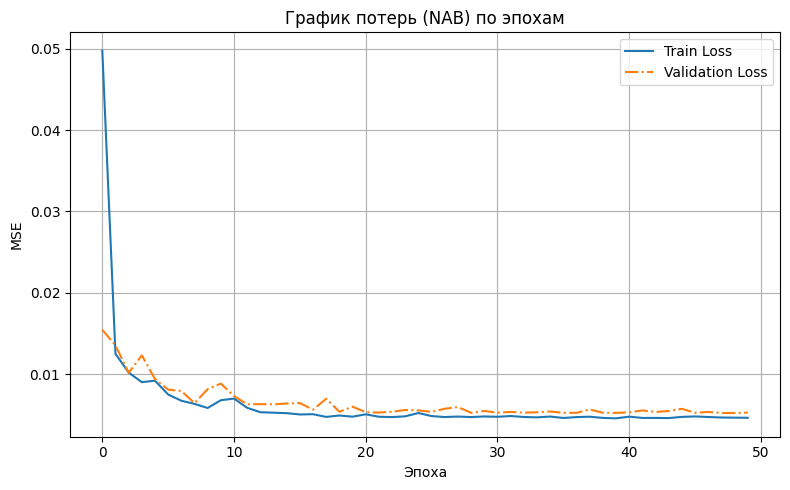

In [7]:
# Построение графика потерь (Loss)
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss', linestyle='-')
plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='-.')
plt.title("График потерь (NAB) по эпохам")
plt.xlabel("Эпоха")
plt.ylabel("MSE")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("loss_ART.png")
plt.show()


Тренируем модель: 2 слоя(ев), 128 нейронов, активация relu, Dropout: False...
Epoch 1/20


C:\Users\HONOR\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - loss: 0.0927 - mse: 0.0927 - val_loss: 0.0175 - val_mse: 0.0175
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 0.0138 - mse: 0.0138 - val_loss: 0.0122 - val_mse: 0.0122
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 0.0125 - mse: 0.0125 - val_loss: 0.0138 - val_mse: 0.0138
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 0.0131 - mse: 0.0131 - val_loss: 0.0113 - val_mse: 0.0113
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 0.0133 - mse: 0.0133 - val_loss: 0.0082 - val_mse: 0.0082
Epoch 6/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 0.0073 - mse: 0.0073 - val_loss: 0.0066 - val_mse: 0.0066
Epoch 7/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 0.0062 - mse: 0.0062 - val_loss: 0.0064 - val_mse: 0.0064
Epoch 8/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 0.0058 - mse: 0.0058 - val_loss: 0.0056 - val_mse: 0.0056
Epoch 9/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss

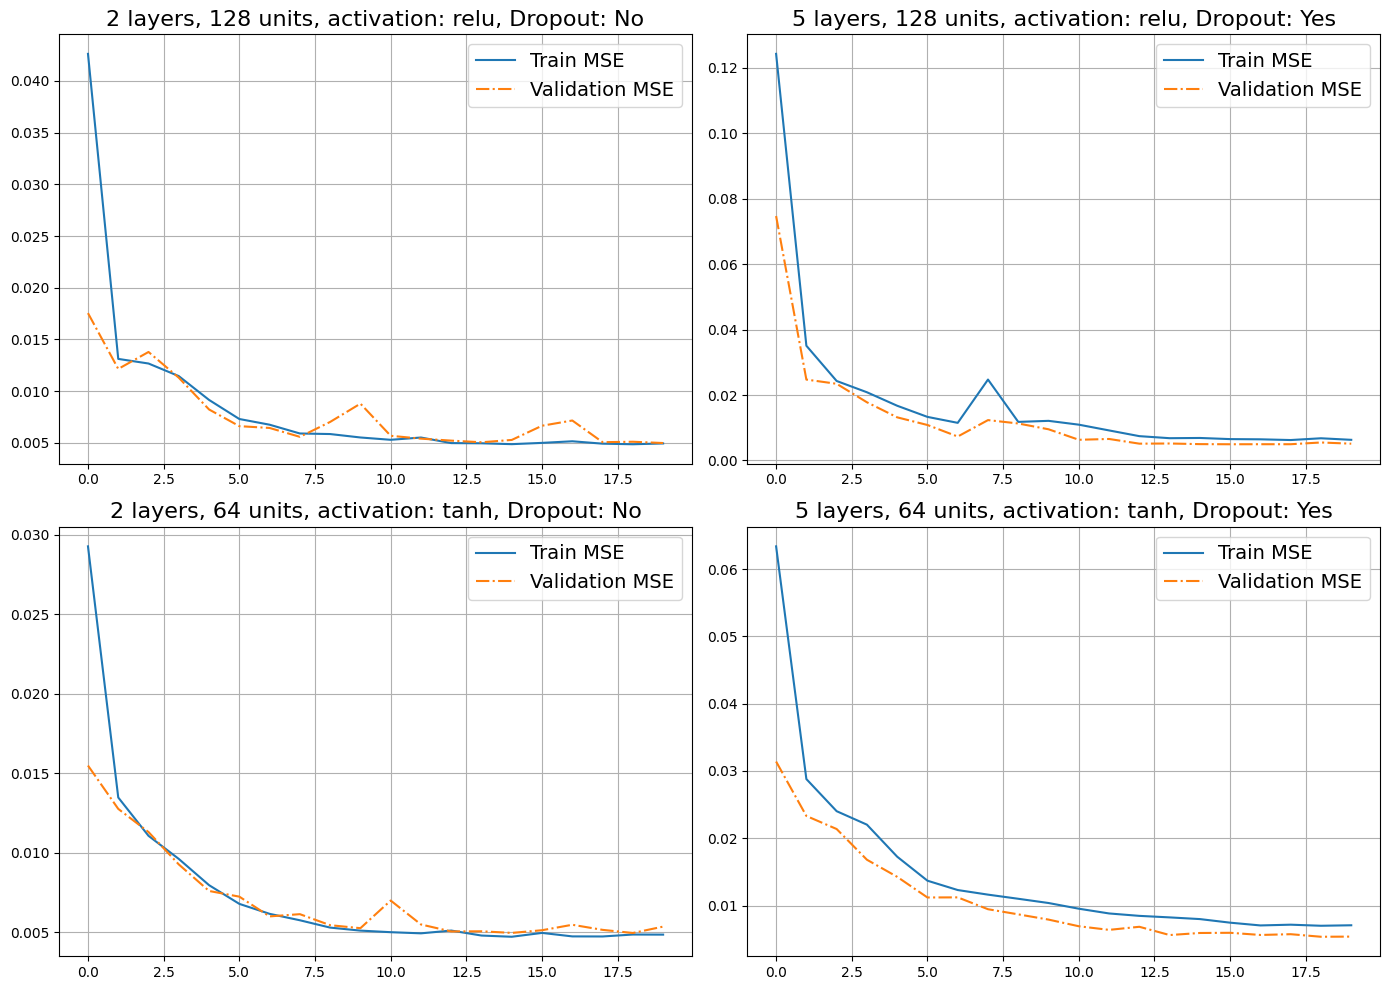


Сравнение моделей  (ART) по минимальному значению MSE на валидации:
Layers: 2, Units: 128, Activation: relu, Dropout: False → Min Val MSE: 0.004987
Layers: 5, Units: 128, Activation: relu, Dropout: True → Min Val MSE: 0.004959
Layers: 2, Units: 64, Activation: tanh, Dropout: False → Min Val MSE: 0.004947
Layers: 5, Units: 64, Activation: tanh, Dropout: True → Min Val MSE: 0.005364


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam

# Загрузка данных
df = pd.read_csv("TIMES/art_daily_no_noise.csv")
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)
df = df.resample("5min").mean()

# Нормализация
data_min = df['value'].min()
data_max = df['value'].max()
df['value'] = (df['value'] - data_min) / (data_max - data_min)

# Подготовка данных
sequence_length = 50
data = df['value'].values
X, y = [], []

for i in range(len(data) - sequence_length):
    X.append(data[i:i + sequence_length])
    y.append(data[i + sequence_length])

X = np.array(X)
y = np.array(y)

# Деление на train/test
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

# Функция модели
def create_model(layers_count, hidden_units, activation, use_dropout):
    model = Sequential()
    model.add(LSTM(hidden_units, activation=activation, input_shape=(sequence_length, 1), return_sequences=(layers_count > 1)))
    for i in range(layers_count - 1):
        model.add(LSTM(hidden_units, activation=activation, return_sequences=(i < layers_count - 2)))
        if use_dropout:
            model.add(Dropout(0.2))
    model.add(Dense(1))
    #model.compile(optimizer=Adam(learning_rate=0.001), loss='mae', metrics=['mse'])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mse'])
    return model


# Эксперименты
experiments = [
    {"layers_count": 2, "hidden_units": 128, "activation": "relu", "use_dropout": False},
    {"layers_count": 5, "hidden_units": 128, "activation": "relu", "use_dropout": True},
    {"layers_count": 2, "hidden_units": 64, "activation": "tanh", "use_dropout": False},
    {"layers_count": 5, "hidden_units": 64, "activation": "tanh", "use_dropout": True},
]

results = []
best_scores = []

# Обучение
for exp in experiments:
    print(f"Тренируем модель: {exp['layers_count']} слоя(ев), {exp['hidden_units']} нейронов, активация {exp['activation']}, Dropout: {exp['use_dropout']}...")
    model = create_model(exp["layers_count"], exp["hidden_units"], exp["activation"], exp["use_dropout"])
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        batch_size=32,
        epochs=20,
        verbose=1
    )
    results.append({
        "params": exp,
        "history": history.history
    })

    min_val_mse = min(history.history["val_mse"])
    best_scores.append({
        "layers": exp["layers_count"],
        "units": exp["hidden_units"],
        "activation": exp["activation"],
        "dropout": exp["use_dropout"],
        "min_val_mse": min_val_mse
    })

# Визуализация: только MSE, 2x2 графика
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, result in enumerate(results):
    params = result["params"]
    history = result["history"]
    
    # Подробный заголовок для графика
    title = (
        f"{params['layers_count']} layers, "
        f"{params['hidden_units']} units, "
        f"activation: {params['activation']}, "
        f"Dropout: {'Yes' if params['use_dropout'] else 'No'}"
    )

    axes[i].plot(history["mse"], label="Train MSE", linestyle='-')
    axes[i].plot(history["val_mse"], label="Validation MSE", linestyle='-.')
    axes[i].set_title(title, fontsize=16)  # Увеличенный шрифт заголовка
    axes[i].legend(fontsize=14)            # Увеличенный шрифт легенды
    axes[i].grid(True)


plt.tight_layout()
plt.savefig('Gr_MSE_ART_UVELICH.png')
plt.show()

# Таблица лучших результатов
print("\nСравнение моделей  (ART) по минимальному значению MSE на валидации:")
for score in best_scores:
    print(f"Layers: {score['layers']}, Units: {score['units']}, Activation: {score['activation']}, Dropout: {score['dropout']} → "
          f"Min Val MSE: {score['min_val_mse']:.6f}")